# Exploration & Single Model Training

---


### Table of Contents:
- <a href='#1'>1. Read Data </a>
- <a href='#2'>2. Descriptive Statistics </a>
- <a href='#3'>3. Model Training </a>
- <a href='#4'>4. Results </a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# diffprivlib
from diffprivlib.tools import mean, histogram

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression as SklearnLogisticRegression

# dp libs
from diffprivlib.models import LogisticRegression

# import from your own module
import sys
sys.path.append("../modules")
from data_utils import load_and_preprocess_titanic

# <a id='1'>1. Read Data</a>
-----

In [2]:
# Load Data
X, y = load_and_preprocess_titanic()
df = pd.concat([X, y], axis=1)

print("\nDescribe the dataset:")
print(df.describe())


Describe the dataset:
           Pclass         Sex         Age       SibSp       Parch        Fare  \
count  891.000000  891.000000  891.000000  891.000000  891.000000  891.000000   
mean     2.308642    0.352413   29.361582    0.523008    0.381594   32.204208   
std      0.836071    0.477990   13.019697    1.102743    0.806057   49.693429   
min      1.000000    0.000000    0.420000    0.000000    0.000000    0.000000   
25%      2.000000    0.000000   22.000000    0.000000    0.000000    7.910400   
50%      3.000000    0.000000   28.000000    0.000000    0.000000   14.454200   
75%      3.000000    1.000000   35.000000    1.000000    0.000000   31.000000   
max      3.000000    1.000000   80.000000    8.000000    6.000000  512.329200   

         Embarked    Survived  
count  891.000000  891.000000  
mean     1.536476    0.383838  
std      0.791503    0.486592  
min      0.000000    0.000000  
25%      1.000000    0.000000  
50%      2.000000    0.000000  
75%      2.000000    1.

# <a id='2'>2. Descriptive Statistics</a>
-----

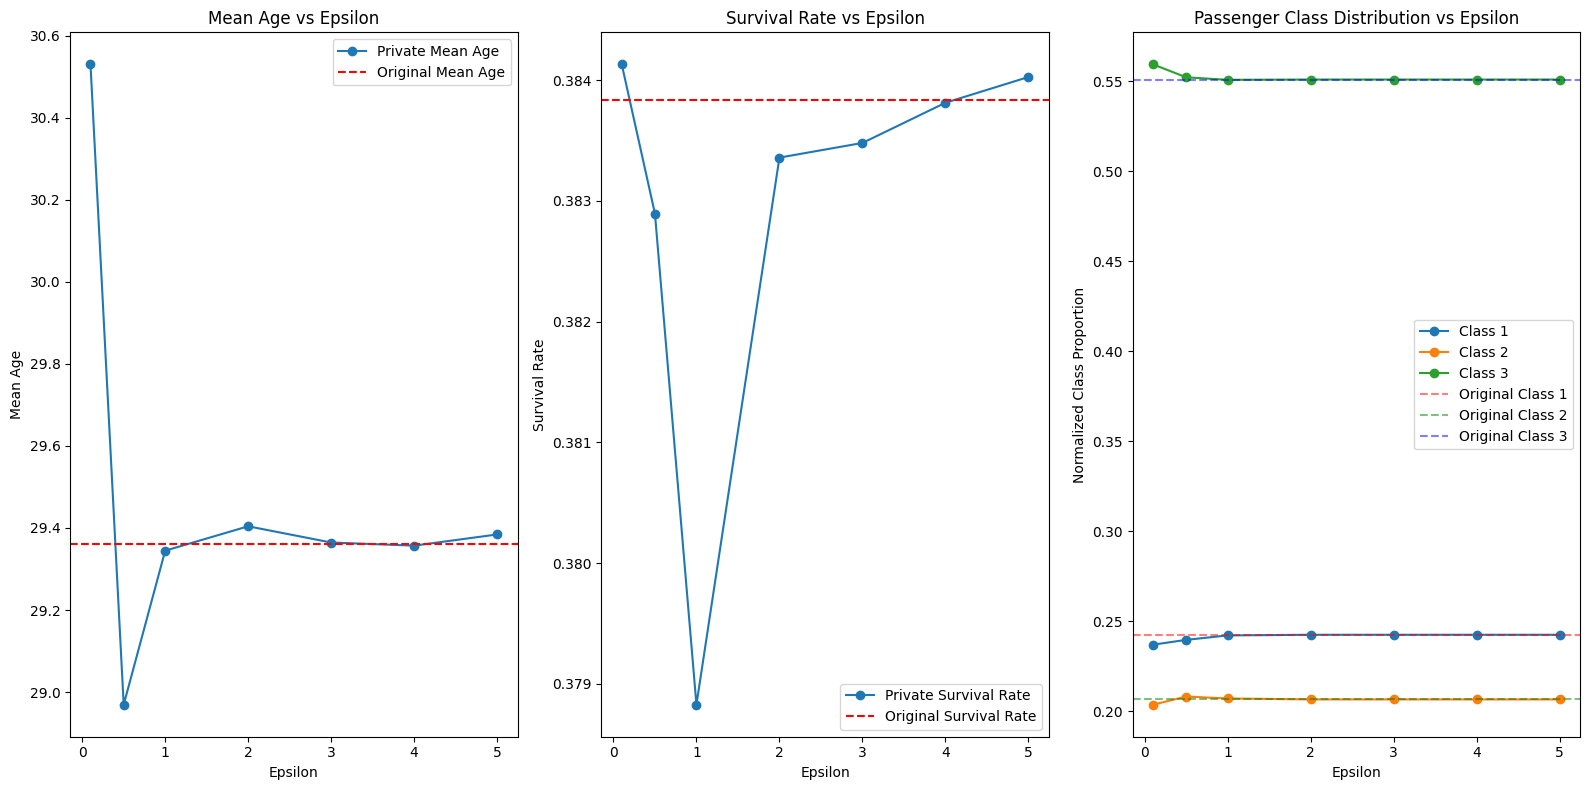

In [3]:
# Define epsilon values to test
epsilon_values = [0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0]

# Original values
original_mean_age = df['Age'].mean()
original_survival_rate = df['Survived'].mean()
original_class_counts = df['Pclass'].value_counts(normalize=True).sort_index()

# Store results for comparison
private_mean_ages = []
private_survival_rates = []
private_class_distributions = []

# Specify bounds
age_bounds = (0, 80)
survived_bounds = (0, 1)
class_range = (1, 3)

# Calculate private statistics for each epsilon
for epsilon in epsilon_values:
    private_mean_ages.append(mean(df['Age'].dropna(), epsilon=epsilon, bounds=age_bounds))
    private_survival_rates.append(mean(df['Survived'], epsilon=epsilon, bounds=survived_bounds))
    private_class_counts, _ = histogram(df['Pclass'], epsilon=epsilon, range=class_range, bins=3)
    private_class_distributions.append(private_class_counts / private_class_counts.sum())

# Plot comparison
plt.figure(figsize=(16, 8))

# Plot mean age
plt.subplot(1, 3, 1)
plt.plot(epsilon_values, private_mean_ages, marker='o', label="Private Mean Age")
plt.axhline(original_mean_age, color='red', linestyle='--', label="Original Mean Age")
plt.title("Mean Age vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Mean Age")
plt.legend()

# Plot survival rate
plt.subplot(1, 3, 2)
plt.plot(epsilon_values, private_survival_rates, marker='o', label="Private Survival Rate")
plt.axhline(original_survival_rate, color='red', linestyle='--', label="Original Survival Rate")
plt.title("Survival Rate vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Survival Rate")
plt.legend()

# Plot class distributions
plt.subplot(1, 3, 3)
for i in range(3):  # Pclass categories: 1, 2, 3
    plt.plot(epsilon_values, [dist[i] for dist in private_class_distributions], marker='o', label=f"Class {i+1}")
plt.axhline(original_class_counts[1], color='red', linestyle='--', label="Original Class 1", alpha=0.5)
plt.axhline(original_class_counts[2], color='green', linestyle='--', label="Original Class 2", alpha=0.5)
plt.axhline(original_class_counts[3], color='blue', linestyle='--', label="Original Class 3", alpha=0.5)
plt.title("Passenger Class Distribution vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Normalized Class Proportion")
plt.legend()

plt.tight_layout()
plt.show()


# <a id='3'>3. Model Training</a>
-----

In [4]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the numerical features
scaler = StandardScaler()
X_train[['Age', 'Fare']] = scaler.fit_transform(X_train[['Age', 'Fare']])
X_test[['Age', 'Fare']] = scaler.transform(X_test[['Age', 'Fare']])

In [5]:
# Train a non-private logistic regression model from sklearn
from sklearn.linear_model import LogisticRegression as SklearnLogisticRegression
non_private_model = SklearnLogisticRegression()
non_private_model.fit(X_train, y_train)

# Evaluate the non-private model
non_private_preds = non_private_model.predict(X_test)
non_private_metrics = {
    'accuracy': accuracy_score(y_test, non_private_preds),
    'precision': precision_score(y_test, non_private_preds),
    'recall': recall_score(y_test, non_private_preds),
    'f1': f1_score(y_test, non_private_preds)
}
print("\nNon-Private Model Metrics:")
print(non_private_metrics)


Non-Private Model Metrics:
{'accuracy': 0.8100558659217877, 'precision': np.float64(0.7857142857142857), 'recall': np.float64(0.7432432432432432), 'f1': np.float64(0.7638888888888888)}


In [6]:
# Calculate the L2 norm of the training data
data_norm = np.linalg.norm(X_train, axis=1).max()
print(f"Calculated data norm (L2): {data_norm:.2f}")

# Train a differentially private logistic regression model
epsilon_values = np.logspace(-3, 5, 300)
private_metrics = []

for epsilon in epsilon_values:
    private_model = LogisticRegression(epsilon=epsilon, data_norm=data_norm)
    private_model.fit(X_train, y_train)
    private_preds = private_model.predict(X_test)

    # Store metrics for comparison
    metrics = {
        'epsilon': epsilon,
        'accuracy': accuracy_score(y_test, private_preds),
        'precision': precision_score(y_test, private_preds, zero_division=0),
        'recall': recall_score(y_test, private_preds),
        'f1': f1_score(y_test, private_preds)
    }
    private_metrics.append(metrics)

Calculated data norm (L2): 9.36


# <a id='4'>4. Results</a>
-----

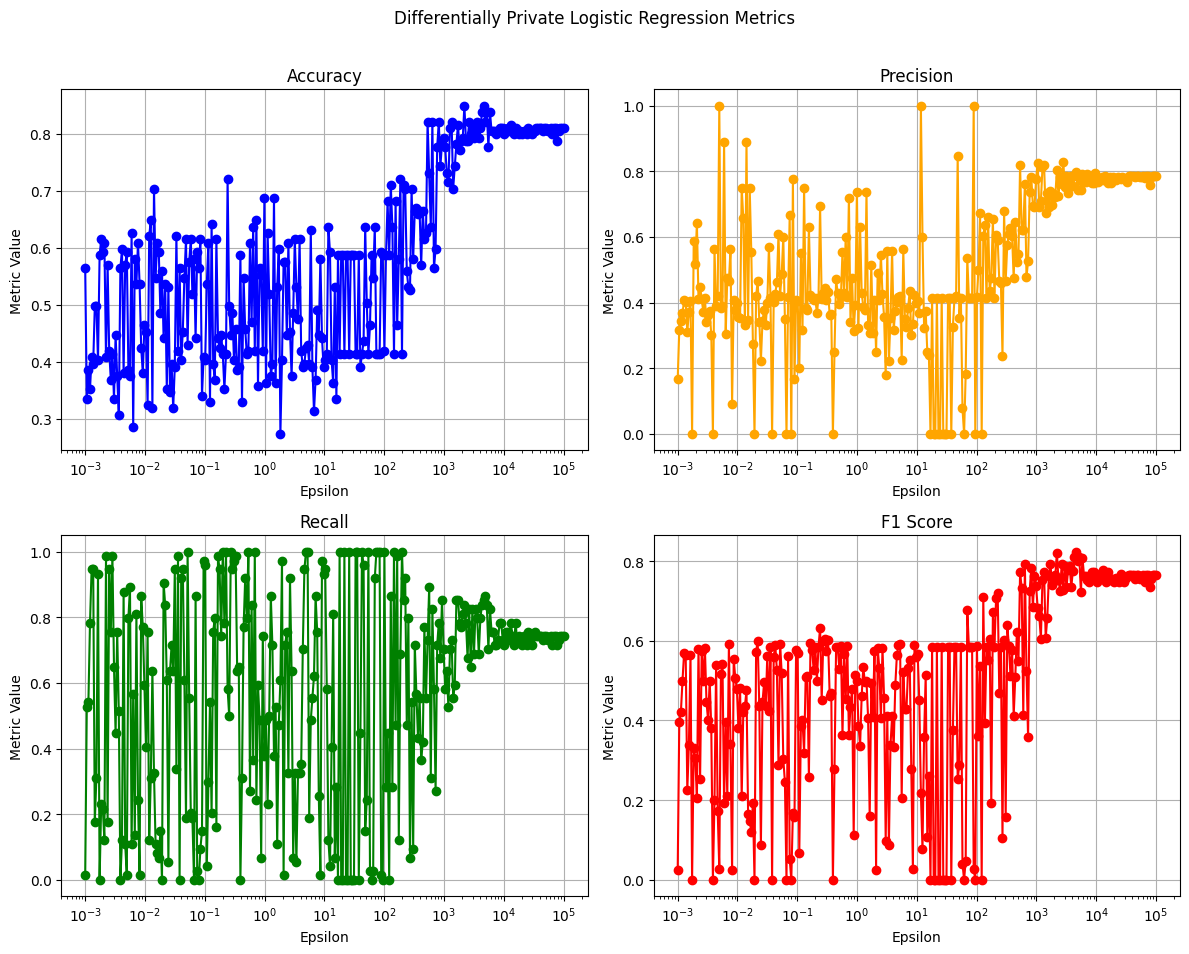

In [7]:
# Convert private metrics to a DataFrame
private_metrics_df = pd.DataFrame(private_metrics)

# Plot metrics for private models in a 2x2 layout
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Accuracy plot
axs[0, 0].plot(private_metrics_df['epsilon'], private_metrics_df['accuracy'], marker='o', color='blue')
axs[0, 0].set_title("Accuracy")
axs[0, 0].set_xlabel("Epsilon")
axs[0, 0].set_ylabel("Metric Value")
axs[0, 0].set_xscale("log")  # Set log scale for x-axis
axs[0, 0].grid()

# Precision plot
axs[0, 1].plot(private_metrics_df['epsilon'], private_metrics_df['precision'], marker='o', color='orange')
axs[0, 1].set_title("Precision")
axs[0, 1].set_xlabel("Epsilon")
axs[0, 1].set_ylabel("Metric Value")
axs[0, 1].set_xscale("log")
axs[0, 1].grid()

# Recall plot
axs[1, 0].plot(private_metrics_df['epsilon'], private_metrics_df['recall'], marker='o', color='green')
axs[1, 0].set_title("Recall")
axs[1, 0].set_xlabel("Epsilon")
axs[1, 0].set_ylabel("Metric Value")
axs[1, 0].set_xscale("log")
axs[1, 0].grid()

# F1 Score plot
axs[1, 1].plot(private_metrics_df['epsilon'], private_metrics_df['f1'], marker='o', color='red')
axs[1, 1].set_title("F1 Score")
axs[1, 1].set_xlabel("Epsilon")
axs[1, 1].set_ylabel("Metric Value")
axs[1, 1].set_xscale("log")
axs[1, 1].grid()

# Adjust layout and show the plot
plt.suptitle("Differentially Private Logistic Regression Metrics")
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


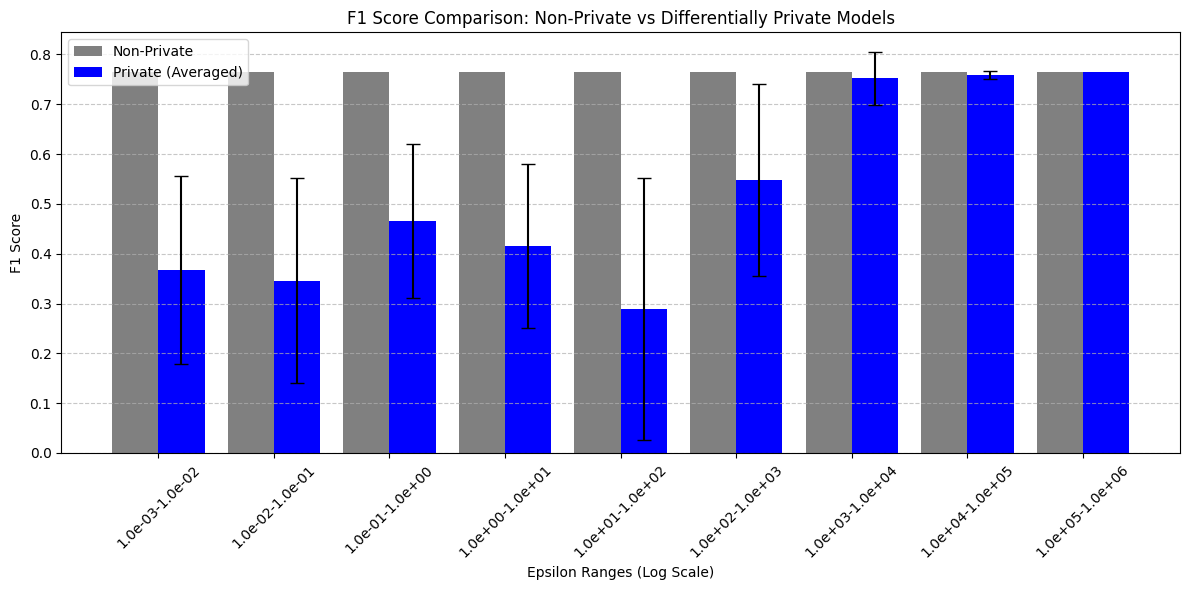

In [8]:
# Define log-discretized epsilon ranges
epsilon_bins = np.logspace(-3, 6, 10)  # 10 bins from 10^-3 to 10^6
range_labels = [f"{epsilon_bins[i]:.1e}-{epsilon_bins[i + 1]:.1e}" for i in range(len(epsilon_bins) - 1)]

f1_avg = []
f1_std = []

# Compute average and standard deviation of F1 scores for each range
for i in range(len(epsilon_bins) - 1):
    mask = (private_metrics_df['epsilon'] >= epsilon_bins[i]) & (private_metrics_df['epsilon'] < epsilon_bins[i + 1])
    avg_f1 = private_metrics_df.loc[mask, 'f1'].mean()
    std_f1 = private_metrics_df.loc[mask, 'f1'].std()
    f1_avg.append(avg_f1)
    f1_std.append(std_f1)

# Plot averaged F1 Score comparison with error bars
plt.figure(figsize=(12, 6))
bar_width = 0.4
x = np.arange(len(range_labels))

# Non-private F1 Score
plt.bar(x - bar_width / 2, [non_private_metrics['f1']] * len(range_labels), 
        bar_width, label="Non-Private", color="gray")

# Private averaged F1 Scores with error bars
plt.bar(x + bar_width / 2, f1_avg, bar_width, yerr=f1_std, label="Private (Averaged)", color="blue", capsize=5)

plt.xlabel("Epsilon Ranges (Log Scale)")
plt.ylabel("F1 Score")
plt.title("F1 Score Comparison: Non-Private vs Differentially Private Models")
plt.xticks(x, range_labels, rotation=45)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()
